# Model for Remote Sensing and Surface Classification 

## General Set-Up 

In [2]:
# main packages
import torch
import os
import pandas as pd
import numpy as np
import random
import re
import cv2

# package dependencies 
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

from PIL import Image

from numpy.linalg import norm
import matplotlib.pyplot as plt

# side packages
import shutil
import glob

# ignore warnings 
import warnings 
warnings.filterwarnings("ignore")

/pfs/data5/home/tu/tu_tu/tu_zxoau27/penv/lib64/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# set a seed for reproduibility
SEED = 123

random.seed(SEED)
torch.manual_seed(SEED)

## Data Management

### Data Preprocessing

In [4]:
if os.path.isdir('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB') is not True: 
    
    # unzip data 
    shutil.unpack_archive('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB.zip',
                        '/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/')
else: 
    pass

In [5]:
imgs = glob.glob('/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB/*tif')
imgs[0]

'/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB/top_potsdam_6_8_RGB.tif'

The format of img is:  TIFF
The mode of img is:  RGB
The size of img is:  (6000, 6000)
The palette of img is:  None


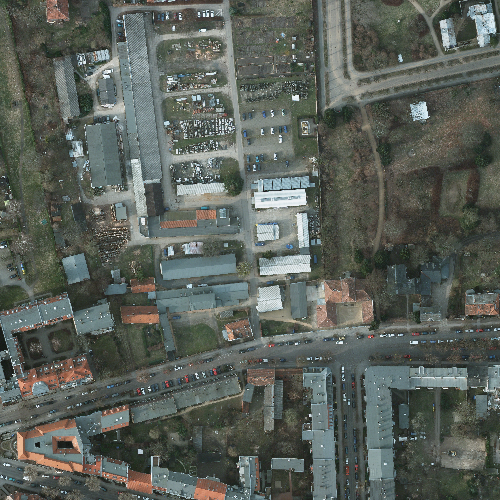

In [6]:
img = Image.open(imgs[0])

print('The format of img is: ', img.format)
print('The mode of img is: ', img.mode)
print('The size of img is: ', img.size)
print('The palette of img is: ', img.palette)

img.resize((500,500), resample=0)

In [7]:
labels = glob.glob("/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/Labels_all/*tif")
label = Image.open(labels[-1])

labels[-1]

'/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/Labels_all/top_potsdam_6_8_label.tif'

The format of label is:  TIFF
The mode of label is:  RGB
The size of label is:  (6000, 6000)
The palette of label is:  None


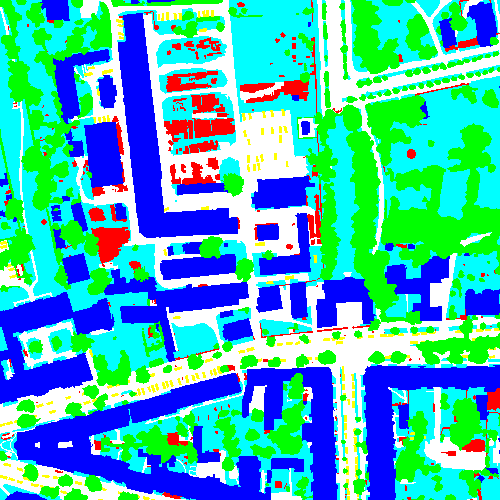

In [8]:
print('The format of label is: ', label.format)
print('The mode of label is: ', label.mode)
print('The size of label is: ', label.size)
print('The palette of label is: ', label.palette)

label.resize((500,500), resample=0)


# Impervious surfaces (RGB: 255, 255, 255)      -> white 
# Building (RGB: 0, 0, 255)                     -> blue 
# Low vegetation (RGB: 0, 255, 255)             -> light-blue
# Tree (RGB: 0, 255, 0)                         -> green            
# Car (RGB: 255, 255, 0)                        -> yellow
# Clutter/background (RGB: 255, 0, 0)           -> red

### Data Structuring

In [9]:
# create dictionary -> {key: 'link/to/image_or_label'}
labels_dict = {label.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : label for label in labels}
imgs_dict = {img.split("/")[-1].split(".")[0].rsplit('_', 1)[0] : img for img in imgs}

# check if keys in both dicts are the same 
set(imgs_dict) == set(labels_dict)

True

In [10]:
keys = sorted(list(set(imgs_dict)))
len(keys)

38

In [11]:
print(labels_dict['top_potsdam_6_8'])
print(imgs_dict['top_potsdam_6_8'])

/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/Labels_all/top_potsdam_6_8_label.tif
/pfs/work7/workspace/scratch/tu_zxobe27-ds_project/data/model_training/2_Ortho_RGB/top_potsdam_6_8_RGB.tif


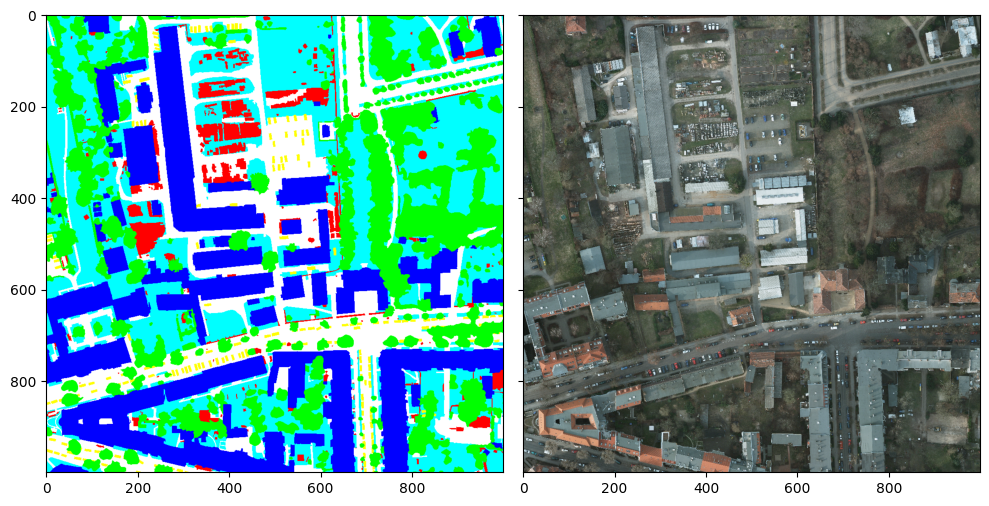

In [39]:
im1 = Image.open(labels_dict['top_potsdam_6_8']).resize((1000, 1000), resample=0)
im2 = Image.open(imgs_dict['top_potsdam_6_8']).resize((1000, 1000), resample=0)

f, ax = plt.subplots(1, 2, figsize=(10,5), sharey=True)
ax[0].imshow(im1) 
ax[1].imshow(im2) 

f.tight_layout()
plt.show()

## Data Import 

In [14]:
convert_tensor = transforms.ToTensor()
convert_tensor(label).shape

torch.Size([3, 6000, 6000])